# Predicting house sale prices
## Skills demonstrated:
1. Data Cleaning
2. Storytelling
3. Linear Regression
4. Feature management
5. Hyperparameter optimization


In this project we are going to practice implementing linear regression model to predict house sale prices.

We'll work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. You can read more about why the data was collected [here](https://doi.org/10.1080/10691898.2011.11889627) . You can also read about the different columns in the data [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

We have a dataset which contains the information about house sales. We want to build a model that will predict the price based on some other characteristics of the houses.

Our pipeline will be as follows:

1. **Cleaning the dataset**. We want to save as much data as possible and after that we will choose features for predictions. The steps are:
    - to manage missing values
    - to edit data types, when it needs
    - to drop columns which can't be used for predictions
    - to manage categorical columns
    
2. **Creating a model** which will predict the price based on choosen features: a linear regression model with given number of folds for training and testing as a parameter. As a start point we will use only one feature for predictions (we'll use Total Condition as it feels like the most correlated with the price). The performance will be evaluated by the mean RMSE for the bias and the standart deviation of RMSEs for the variance. 

3. **Making the hyperparameter optimization**. We'll try different k-value for the KFold validation

4. **Testing the model**. As a start point we will implement the model on 3 basic sets of features:
    - All numerical features
    - All avaliable features (both numerical and categorical)
    
5. **Experimenting with the features**. At this stage we will try to encrease the performance of the model by choosing different combinations of features. The ideas are:
    - to choose the only features that correlate highly with the target field
    - to exclude features that highly correlate between each other 

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = 999

In [2]:
houses = pd.read_csv('AmesHousing.tsv', delimiter = '\t')

In [3]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

## 1. Data cleaning
### 1.1. Dealing with nulls

We'll create a function which takes in a dataframe and returns the number of Null-values for each of its column

In [4]:
def get_nulls(df):
    null_df = pd.DataFrame({'types': df.dtypes,
                            'nulls': df.isnull().sum(),
                            'nulls_%': df.isnull().sum() / df.shape[0]*100})
    null_df = null_df[null_df['nulls']>0].sort_values('nulls', ascending=False)
    return null_df

In [5]:
nulls_df = get_nulls(houses)
nulls_df

,types,nulls,nulls_%
Pool QC,object,2917,99.556314
Misc Feature,object,2824,96.382253
Alley,object,2732,93.242321
Fence,object,2358,80.477816
Fireplace Qu,object,1422,48.532423
Lot Frontage,float64,490,16.723549
Garage Cond,object,159,5.426621
Garage Qual,object,159,5.426621
Garage Finish,object,159,5.426621
Garage Yr Blt,float64,159,5.426621


We can see there are 6 columns with 16% and more of null values. We'll drop them.

In [6]:
columns_to_drop = nulls_df[nulls_df['nulls_%']>15].index
houses.drop(columns=columns_to_drop, inplace=True)
nulls_df = get_nulls(houses)
nulls_df

,types,nulls,nulls_%
Garage Cond,object,159,5.426621
Garage Qual,object,159,5.426621
Garage Finish,object,159,5.426621
Garage Yr Blt,float64,159,5.426621
Garage Type,object,157,5.358362
Bsmt Exposure,object,83,2.832765
BsmtFin Type 2,object,81,2.764505
Bsmt Qual,object,80,2.730375
Bsmt Cond,object,80,2.730375
BsmtFin Type 1,object,80,2.730375


Exploring garage-columns.

After exploring 7 columns that describe garages in different aspects, we can suggest, that the most useful characteristic is whether there is a garage at all and how many cars it can accomodate. So we can drop all columns except **'Garage Cars'**. But there are 1 missing value, which we must fix. We will replace NULL by '0' and drop all other columns with the word "Garage"

In [7]:
houses['Garage Cars'].value_counts(dropna=False)

2.0    1603
1.0     778
3.0     374
0.0     157
4.0      16
5.0       1
NaN       1
Name: Garage Cars, dtype: int64

In [8]:
houses['Garage Cars'].fillna(0, inplace=True)
nulls_df = get_nulls(houses)
nulls_df

,types,nulls,nulls_%
Garage Cond,object,159,5.426621
Garage Qual,object,159,5.426621
Garage Finish,object,159,5.426621
Garage Yr Blt,float64,159,5.426621
Garage Type,object,157,5.358362
Bsmt Exposure,object,83,2.832765
BsmtFin Type 2,object,81,2.764505
Bsmt Qual,object,80,2.730375
Bsmt Cond,object,80,2.730375
BsmtFin Type 1,object,80,2.730375


In [9]:
garage_nulls = nulls_df.index[nulls_df.index.str.contains(r'Garage')]
houses.drop(columns = garage_nulls, inplace=True)
nulls_df = get_nulls(houses)
nulls_df

,types,nulls,nulls_%
Bsmt Exposure,object,83,2.832765
BsmtFin Type 2,object,81,2.764505
Bsmt Qual,object,80,2.730375
Bsmt Cond,object,80,2.730375
BsmtFin Type 1,object,80,2.730375
Mas Vnr Type,object,23,0.784983
Mas Vnr Area,float64,23,0.784983
Bsmt Full Bath,float64,2,0.068259
Bsmt Half Bath,float64,2,0.068259
BsmtFin SF 1,float64,1,0.034130


Cleaning 'Basement' - columns

We have many columns that describe basements, but there is one that could be enough - total area of the basement. There are 1 missing value, that we must manage it. After that we can drop all other columns that describe a basement

In [10]:
houses['Total Bsmt SF'].value_counts()

0.0       79
864.0     74
672.0     29
912.0     26
1040.0    25
          ..
839.0      1
1146.0     1
1415.0     1
1684.0     1
1003.0     1
Name: Total Bsmt SF, Length: 1058, dtype: int64

In [11]:
houses['Total Bsmt SF'].fillna(0, inplace=True)
nulls_df = get_nulls(houses)
nulls_df

,types,nulls,nulls_%
Bsmt Exposure,object,83,2.832765
BsmtFin Type 2,object,81,2.764505
Bsmt Qual,object,80,2.730375
Bsmt Cond,object,80,2.730375
BsmtFin Type 1,object,80,2.730375
Mas Vnr Type,object,23,0.784983
Mas Vnr Area,float64,23,0.784983
Bsmt Full Bath,float64,2,0.068259
Bsmt Half Bath,float64,2,0.068259
BsmtFin SF 1,float64,1,0.034130


In [12]:
bsmt_nulls = nulls_df.index[nulls_df.index.str.contains(r'Bsmt')]
bsmt_nulls
houses.drop(columns=bsmt_nulls, inplace=True)
get_nulls(houses)

,types,nulls,nulls_%
Mas Vnr Type,object,23,0.784983
Mas Vnr Area,float64,23,0.784983
Electrical,object,1,0.034130


The *Mas Vnr Type* and *Mas Vnr Area* columns holds quite the same information, so we can drop one and fill anothers with the most popular value for each

In [13]:
houses['Mas Vnr Type'].value_counts(dropna=False)

None       1752
BrkFace     880
Stone       249
BrkCmn       25
NaN          23
CBlock        1
Name: Mas Vnr Type, dtype: int64

In [14]:
houses['Mas Vnr Type'].fillna('None', inplace=True)
houses.drop(columns=['Mas Vnr Area'], inplace=True)

In [15]:
houses['Electrical'].value_counts(dropna=False)

SBrkr    2682
FuseA     188
FuseF      50
FuseP       8
NaN         1
Mix         1
Name: Electrical, dtype: int64

In [16]:
houses['Electrical'].fillna('SBrkr', inplace=True)

In [17]:
get_nulls(houses)

,types,nulls,nulls_%


### 1.2. Cleaning numerical columns

The only numerical columns that are absolutely irrelevant as features are: **'Order'** and **'PID'**. We'll drop them

The only numerical column that reflects categories is **'MS SubClass'**. We'll convert it 

Some columns we can use for creating new features are: **'Year Built', 'Year Remod/Add', 'Yr Sold', 'Mo Sold'**. We'll create a couple of new features and drop the initial columns

In [18]:
houses['years_since_built'] = houses['Yr Sold'] - houses['Year Built']
houses['years_since_remod'] = houses['Yr Sold'] - houses['Year Remod/Add']

In [19]:
houses[houses['years_since_built']<0]

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Exter Qual,Exter Cond,Foundation,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,years_since_built,years_since_remod
2180,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,Ex,TA,PConc,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,2,1,2,1,Ex,15,Typ,2,3.0,Y,546,484,0,0,0,0,17000,10,2007,New,Partial,183850,-1,-2


In [20]:
houses[houses['years_since_remod']<0]

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Exter Qual,Exter Cond,Foundation,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,years_since_built,years_since_remod
1702,1703,528120010,60,RL,16659,Pave,IR1,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,8,5,2007,2008,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,1582.0,GasA,Ex,Y,SBrkr,1582,570,0,2152,2,1,3,1,Gd,7,Typ,1,2.0,Y,0,368,0,0,0,0,0,6,2007,New,Partial,260116,0,-1
2180,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,Ex,TA,PConc,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,2,1,2,1,Ex,15,Typ,2,3.0,Y,546,484,0,0,0,0,17000,10,2007,New,Partial,183850,-1,-2
2181,2182,908154205,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,Ex,TA,PConc,3138.0,GasA,Ex,Y,SBrkr,3138,1538,0,4676,3,1,3,1,Ex,11,Typ,1,3.0,Y,208,406,0,0,0,0,0,10,2007,New,Partial,184750,0,-1


In [21]:
houses.drop(columns=['Order', 'PID','Year Built', 'Year Remod/Add', 'Mo Sold'], inplace= True)
houses.drop(index=[2180, 1702, 2181], inplace= True)

houses['MS SubClass'] = houses['MS SubClass'].astype('category')

### 1.3. Unpivoting categorical columns
First we'll see how many unique values are there in each text column

In [22]:
obj_columns = houses.select_dtypes('object').columns
columns = []
unique_values = []
for col in obj_columns:
    houses[col] = houses[col].astype('category')
    unique_values.append(houses[col].nunique())
    columns.append(col)
unique_values_df = pd.DataFrame({'Column': columns,
                                 'Num_unique_values': unique_values})
unique_values_df.sort_values('Num_unique_values', 
                             ascending=False).reset_index(drop=True)

,Column,Num_unique_values
0,Neighborhood,28
1,Exterior 2nd,17
2,Exterior 1st,16
3,Sale Type,10
4,Condition 1,9
5,Condition 2,8
6,Functional,8
7,Roof Matl,8
8,House Style,8
9,MS Zoning,7


Now, we'll create a function, which unpivot all non-numerical columns or get **dummies**. The parameter **max_values** determines the maximum number of unique values in the column that will be unpivoted

In [23]:
def unpivot(df, max_values=28):    
    cat_columns = df.select_dtypes(['category']).columns
    extended_df = df.copy()
    for col in cat_columns:
        if df[col].nunique() <= max_values:
            extended_df = pd.concat([extended_df, pd.get_dummies(df[col], prefix=col)],
                                    axis=1)
        extended_df.drop(columns=col, inplace=True)
    return extended_df

## 2. Creating a model
We'll create a function which:
1. takes in the dataframe, and the number of folds we want to use for cross validation
2. treats the **SalePrice** column as a target and the rest numeric columns as features
3. trains the **Linear Regression model**
4. makes predictions
5. returns the mean RMSE value and the standart deviation for all RMSE values (if the number of folds is more than 2).

In [24]:
def train_and_test(df, num_folds = 2):
    numeric_df = df.select_dtypes(np.number)
    features = numeric_df.drop(columns='SalePrice').columns
    lr = LinearRegression()
        
    if num_folds < 2:
        middle_value = int(len(numeric_df)/2)
        train = numeric_df.iloc[:middle_value] 
        test = numeric_df.iloc[middle_value:]   
        lr.fit(train[features], train['SalePrice'])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test['SalePrice'], predictions)
        rmse = np.sqrt(mse)
        rmses_std = 0        
    else:
        kf = KFold(n_splits=num_folds,
                   shuffle=True,
                   random_state=1)
        
        mses = cross_val_score(lr,
                               numeric_df[features],
                               numeric_df['SalePrice'],
                               scoring='neg_mean_squared_error',
                               cv=kf                           
                              )        
        rmses = np.sqrt(np.abs(mses))
        rmse = np.mean(rmses)
        rmses_std = np.std(rmses)    
    return round(rmse,2), round(rmses_std,2)

In [25]:
one_featured_df = houses[["Overall Qual", "SalePrice"]]
rmse, rmses_std = train_and_test(one_featured_df)
rmse, rmses_std

(47862.1, 1062.89)

## 3. Choosing the default number of folds for KFold validation

In [26]:
rmses = []
stds = []
folds = []
for k in range(1, 15):
    rmse, rmses_std = train_and_test(one_featured_df, k)
    rmses.append(rmse)
    stds.append(rmses_std)
    folds.append(k)
folds_df = pd.DataFrame({'Folds': folds,
                         'RMSE': rmses,
                         'Std': stds                     
                        })
folds_df

,Folds,RMSE,Std
0,1,49179.44,0.00
1,2,47862.10,1062.89
2,3,47917.76,1596.99
3,4,47832.15,2592.86
4,5,47779.55,3033.67
5,6,47792.19,3700.92
6,7,47797.82,2178.01
7,8,47805.91,2812.22
8,9,47776.54,2881.42
9,10,47743.43,3354.29


We can see, that changing the number of folds doesn't affect much on RMSE, while StD changes much more. So, for now we can say **2** folds is the best choice

## 4.1. All numerical features
As a start point let's try to use all numerical features for predictions, and then try to choose only relevant ones

In [27]:
# We take all features before unpivoting categorical values

rmse_all_numeric = train_and_test(houses)
rmse_all_numeric

(33065.08, 2419.59)

## 4.2. All avaliable features

In [28]:
# We take all avaliable features: all initial numerical and all dummied categorical

houses_extended = unpivot(houses)
rmse_all_avaliable = train_and_test(houses_extended)
rmse_all_avaliable

(29414.47, 1315.13)

## 5. Feature engineering

It seems for now, that the more features are used the higher performance we get. Let's see whether we can improve the performance by choosing only some set of features.

The first step is to choose only features that correlates with the target column most

In [29]:
# We can treat both positive and negative correlation strengths equally

df_corr = abs(houses_extended.corr())
df_corr[['SalePrice']].sort_values(by='SalePrice', ascending=False)

,SalePrice
SalePrice,1.000000
Overall Qual,0.801206
Gr Liv Area,0.717596
Garage Cars,0.648111
Total Bsmt SF,0.644012
...,...
Condition 2_RRAe,0.002136
Condition 1_RRAn,0.001067
Sale Type_ConLI,0.000459
Roof Matl_Metal,0.000177


Let's create a function which selects the only features which correlate with the 'Sale Price' more than some threshold value (let it be 0.4 by default).

In [30]:
def select_features(df,threshold=0.4):
    df_corr = abs(df.corr())
    columns_to_drop = df_corr[df_corr['SalePrice'] < threshold]['SalePrice'].index
    df_filtered = df.drop(columns=columns_to_drop)
    
    return df_filtered

In [31]:
df_filtered = select_features(houses_extended)
train_and_test(df_filtered)

(31150.37, 1386.19)

## 5.1. Experimenting with correlation threshold
Now we are going to reduce the number of features by taking only those which correlates with the target more than a threshold-value. We'll move this threshold to see how it affects on the performance

In [32]:
rmses = []
stds = []
thresholds = []
features_used = []

for k in range(0,80,5):
    df_filtered = select_features(houses_extended, k/100)
    rmse, rmses_std = train_and_test(df_filtered, 2)
    rmses.append(rmse)
    stds.append(rmses_std)
    thresholds.append(k/100)
    features_used.append(len(df_filtered.columns)-1)
    
thresholds_df = pd.DataFrame({'threshold': thresholds,
                              'features_used': features_used,
                              'RMSE': rmses,
                              'Std': stds                     
                             })
thresholds_df

,threshold,features_used,RMSE,Std
0,0.00,244,29414.47,1315.13
1,0.05,148,29082.57,846.15
2,0.10,105,28651.49,1391.58
3,0.15,62,29697.65,1249.97
4,0.20,52,29939.58,1325.71
5,0.25,43,30215.53,1692.09
6,0.30,31,30991.74,1349.29
7,0.35,22,31182.07,1426.73
8,0.40,18,31150.37,1386.19
9,0.45,16,31257.97,1428.99


We can see that the best performance (either by bias and variance) is lying somewhere between the threshold values 0 and 0.1. Lets try to dive further and reduce the step. 

In [33]:
rmses = []
stds = []
thresholds = []
features_used = []

for k in range(0,10):
    df_filtered = select_features(houses_extended, k/100)
    rmse, rmses_std = train_and_test(df_filtered, 2)
    rmses.append(rmse)
    stds.append(rmses_std)
    thresholds.append(k/100)
    features_used.append(len(df_filtered.columns)-1)
    
thresholds_df = pd.DataFrame({'threshold': thresholds,
                              'features_used': features_used,
                              'RMSE': rmses,
                              'Std': stds                     
                             })
thresholds_df

,threshold,features_used,RMSE,Std
0,0.00,244,29414.47,1315.13
1,0.01,229,29399.95,684.91
2,0.02,210,29318.42,881.65
3,0.03,182,29135.90,762.41
4,0.04,167,29280.11,829.72
5,0.05,148,29082.57,846.15
6,0.06,138,29152.46,765.46
7,0.07,122,29157.49,887.74
8,0.08,114,29274.69,880.26
9,0.09,111,29168.71,995.23


It seems that 0.03 is the best threshold value

## 5.2. Excluding features that duplicate each other.
Let's see how excluding features that highly correlate with each other will affect on the model's performance

In [34]:
def drop_corr_features(df, corr_threshold=0.8):    
    df_filtered = select_features(df, 0.03)
    all_features = df_filtered.drop(columns='SalePrice')

    features_corr = abs(all_features.corr())
    correlated_features = set()

    for i in range(len(features_corr.index)):
        for j in range(i):
            if features_corr.iloc[i, j] > corr_threshold:
                colname = features_corr.columns[i]
                correlated_features.add(colname) 
                
    return df_filtered.drop(columns=correlated_features)

In [35]:
rmses = []
stds = []
thresholds = []
features_used = []

for k in range(50,99,5):
    df_clear = drop_corr_features(houses_extended, k/100)
    rmse, rmses_std = train_and_test(df_clear)
    rmses.append(rmse)
    stds.append(rmses_std)
    thresholds.append(k/100)
    features_used.append(len(df_clear.columns)-1)
    
thresholds_df = pd.DataFrame({'threshold': thresholds,
                              'features_used': features_used,
                              'RMSE': rmses,
                              'Std': stds                     
                             })
thresholds_df

,threshold,features_used,RMSE,Std
0,0.50,118,35320.99,187.43
1,0.55,125,32742.90,766.96
2,0.60,133,31601.13,693.88
3,0.65,142,30617.79,475.87
4,0.70,145,28700.95,603.93
5,0.75,147,28714.22,617.88
6,0.80,154,28759.53,626.29
7,0.85,160,28867.65,638.96
8,0.90,168,28887.51,627.97
9,0.95,173,29050.71,714.95


## Summing up:

Now, let's see how feature management has affected on the model performance

In [36]:
results = {}

one_featured_df = houses[["Overall Qual", "SalePrice"]]
results['one feature'] = train_and_test(one_featured_df)

results['all numerical'] = train_and_test(houses)

results['all avaliable'] = train_and_test(houses_extended)

df_only_high_correlated_with_the_target = select_features(houses_extended, 0.03)
results['only highly correlated'] = train_and_test(df_only_high_correlated_with_the_target)

df_cleared_from_high_correlated_with_each_other = drop_corr_features(houses_extended, 0.7)
results['without pairwise correlated'] = train_and_test(df_cleared_from_high_correlated_with_each_other)

results_df = pd.DataFrame.from_dict(results, 'index')
results_df.columns = ['RMSE', 'StD RMSE']
results_df

,RMSE,StD RMSE
one feature,47862.10,1062.89
all numerical,33065.08,2419.59
all avaliable,29414.47,1315.13
only highly correlated,29135.90,762.41
without pairwise correlated,28700.95,603.93


It is make sence to look at the range of the values in our target column for better understanding the RMSE in predictions

In [37]:
print(houses.describe()['SalePrice'])

count      2927.000000
mean     180766.566450
std       79914.124173
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64


Let's visualize the results

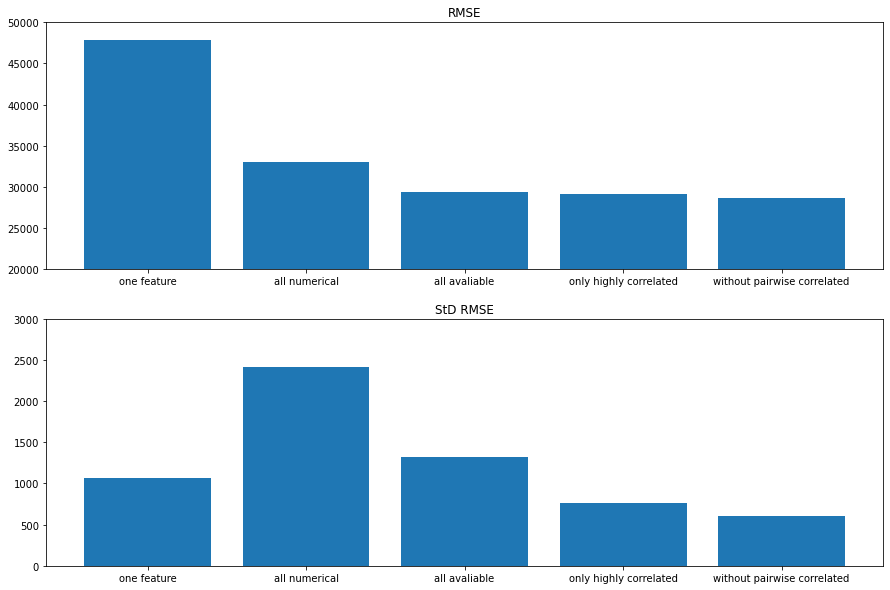

In [38]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

axs[0].bar(results_df.index, results_df['RMSE'])
axs[0].set_title('RMSE')
axs[0].set_ylim(20000,50000)

axs[1].bar(results_df.index, results_df['StD RMSE'])
axs[1].set_title('StD RMSE')
axs[1].set_ylim(0,3000)

plt.show()

Looks like feature management makes sence, as we've hugely increased our results

## 6. Conclusion
We can see how important the feature management is. Simply taking all the avaliable features and making predictions on them won't lead to the best performance.